# JOB Interview - Data Analyst

Welcome to this notebook! Here I present the approach I took to analyse the dataset the interviewers sent to me during a "Data Analyst" job interview process. The R&D department operates in the healthcare sector and produces hearing aids for B2B. The following steps were taken:
<br><br>
1. Understanding the Problem & Setting the Scene
2. Setting up the infrastructure
3. Getting Data
4. Exploratory Data Analysis - Python
    1. Sneak Peak
    2. Types of columns & description
    3. Descriptive Statistics
    4. Plots & Questions (includes new features)
6. Results & Limitations
7. Sources Used

## 1. Understanding the Problem

The interviewers have provided a dataset in the ```.csv```-format to the potential candidate (me). The formulated task, by the interviewers, is to "showcase your skills and investigate the dataset". The interview is scheduled to take place a week after receiving the dataset. In this appointment the interviewee will need to present his results. Emphasis is placed on written code. <b>No further instructions have been made. </b> The R&D department offering the Data Analyst position are looking for support due to the growing amount of requests.

However, the interviewee has deducted that the following requirements need to be met to some extent, in order for him to proceed to the interview stage 2. He also wants to use this interview as an opportunity to learn new things. He bases his assumptions on information provided in a screening interview and the job position:

  * a) Company language is English, therefore code and explanations should meet this requirement
  * b) Programming skills in Python, SQL as well Power BI (DAX / M-Language) should be incorporated, as the department relies on these for coding
  * c) Coding principles should be followed ("Commit early, commit often", commented code, clean code)
  * d) Deliver high quality analytics in easy and understandable way
  * e) Answering common data analytics questions using EDA for the dataset
  * f) Data pipelines should be implemented
  * g) Utilizing Apache Spark (pyspark), Azure Services and ML methods are icing on the cake!

## 2. Setting up the infrastructure

[![IMAGE ALT TEXT HERE](https://github.com/sibr1011/job_interview/blob/main/pics/pipeline.png?raw=true)](https://github.com/sibr1011/job_interview/blob/main/pics/pipeline.png?raw=true)

The image above illustrates the process that was taken for the task at hand. The provided ```.csv``` was uploaded to github. In this notebook we read the file directly into spark. After feature generation and cleaning has taken place, we will store the date in a Hive Database.

This section focues on Problems f) and partly g) from section *1. Understanding the Problem.*

## 3. Getting Data & Cleaning

In [0]:
# imports
import pyspark as ps
from pyspark.sql.types import StructField, StructType, DateType, StringType
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark import SparkFiles
from pyspark.sql import functions as F
from functools import reduce
import pandas as pd
import sys


# url for csv
url = "https://raw.githubusercontent.com/sibr1011/job_interview/main/WSA_jobinterviewdata.csv"

# variables for writing back later
appName= "hive_metastore"
master= "local"

In [0]:
# initialize session for writing data back later
spark = SparkSession.builder.appName('Interview CSV').getOrCreate()

In [0]:
# loading data from csv to pyspark df
spark.sparkContext.addFile(url)

In [0]:
# seems to be a bug where the file lands -> https://stackoverflow.com/questions/70246983/sparkfiles-path-not-found
SparkFiles.getRootDirectory()

Out[254]: '/local_disk0/spark-0b472f66-bd7c-494a-b20d-f632f81d531c/userFiles-412ede6b-640d-4d88-952a-a8068bc282b6'

In [0]:
# read the file with schema
df = spark.read.csv(SparkFiles.get("/local_disk0/WSA_jobinterviewdata.csv"), inferSchema=True, header=True)

# rename cols
old_col_names = df.schema.names
new_col_names = ["patient", "action", "org_resource", "date_time"]
df = reduce(lambda df, idx: df.withColumnRenamed(old_col_names[idx], new_col_names[idx]), range(len(old_col_names)), df)

In [0]:
# now the schema is the way we want it
print(df.printSchema())

# create pandasDF just for fun
pandasDF = df.toPandas()

# trim leading / trailing whitspaces
pandasDF['action'] = pandasDF['action'].str.strip()
pandasDF['org_resource'] = pandasDF['org_resource'].str.strip()
pandasDF['patient'] = pandasDF['patient'].str.strip()

# give each patient an id
pandasDF['patient_id'] = pandasDF.groupby(['patient']).ngroup()
pandasDF['id'] = pandasDF.reset_index().index

# reorder columns
pandasDF = pandasDF[['id', 'patient_id', 'patient', 'action', 'org_resource', 'date_time']]
print(pandasDF.columns)

root
 |-- patient: string (nullable = true)
 |-- action: string (nullable = true)
 |-- org_resource: string (nullable = true)
 |-- date_time: timestamp (nullable = true)

None
Index(['id', 'patient_id', 'patient', 'action', 'org_resource', 'date_time'], dtype='object')


In [0]:
type(df)

Out[257]: pyspark.sql.dataframe.DataFrame

## 4. Exploratory Data Analysis

### 4.1 Sneak Peak

In [0]:
# 1. shape / counts -> 690 rows, 4 columns
print("records ct: ", df.count())
print("columns ct: ", sum(1 for x in df.columns))

records ct:  690
columns ct:  4


In [0]:
# 1. head() - i think the output looks better in pandas df
pandasDF.head(10)

,id,patient_id,patient,action,org_resource,date_time
0,0,0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,1,0,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,2,0,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,3,0,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,4,0,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09
5,5,0,patient 0,Final consult,Dr. Ben,2017-01-09 08:29:28
6,6,1,patient 1,First consult,Dr. Anna,2017-01-02 12:50:35
7,7,1,patient 1,Physical test,Nurse Jesse,2017-01-02 13:59:14
8,8,1,patient 1,Blood test,Lab,2017-01-02 14:20:19
9,9,1,patient 1,X-ray scan,Team 1,2017-01-06 09:13:40


In [0]:
# 1. tail - same here
pandasDF.tail(10)

,id,patient_id,patient,action,org_resource,date_time
680,680,98,patient 98,Second consult,Dr. Anna,2017-05-26 11:53:12
681,681,98,patient 98,Surgery,Dr. Alex,2017-05-30 14:13:17
682,682,98,patient 98,Final consult,Dr. Ben,2017-05-31 14:16:13
683,683,99,patient 99,First consult,Dr. Bob,2017-05-18 11:57:11
684,684,99,patient 99,Blood test,Lab,2017-05-18 13:13:44
685,685,99,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27
686,686,99,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24
687,687,99,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39
688,688,99,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13
689,689,99,patient 99,Final consult,Dr. Anna,2017-05-31 12:46:43


### 4.2 Types of columns and description

In [0]:
# schema - 4 vars.
print(df.columns)

['patient', 'action', 'org_resource', 'date_time']


In [0]:
# types of elements
for field in df.schema.fields:
    print(field.name +" , "+str(field.dataType))

patient , StringType()
action , StringType()
org_resource , StringType()
date_time , TimestampType()


### 4.3 Descriptive Statistics

In [0]:
# get descriptive statistics for all columns
print(df.select('patient').describe().show())
print(df.select('action').describe().show())
print(df.select('org_resource').describe().show())
print(df.select('date_time').describe().show())

+-------+----------+
|summary|   patient|
+-------+----------+
|  count|       690|
|   mean|      null|
| stddev|      null|
|    min| patient 0|
|    max|patient 99|
+-------+----------+

None
+-------+-----------+
|summary|     action|
+-------+-----------+
|  count|        690|
|   mean|       null|
| stddev|       null|
|    min| Blood test|
|    max| X-ray scan|
+-------+-----------+

None
+-------+------------+
|summary|org_resource|
+-------+------------+
|  count|         690|
|   mean|        null|
| stddev|        null|
|    min|    Dr. Alex|
|    max|      Team 2|
+-------+------------+

None
+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

None


In [0]:
# any missing values?
print(pandasDF.isnull().values.any())

# alternatively in pyspark
# df.select("patient", "action", "org_resource", "date_time").filter(col("patient")).isNull().count()

False


In [0]:
# get distinct amount of patients / actions / resources
distinct_patients = F.countDistinct("patient").alias("distinct_patients")
distinct_actions = F.countDistinct("action").alias("distinct_actions")
distinct_resources = F.countDistinct("org_resource").alias("distinct_resources")
distinct_date_times = F.countDistinct("date_time").alias("distinct_date_times")

df.select(distinct_patients, distinct_actions, distinct_resources, distinct_date_times).show()

+-----------------+----------------+------------------+-------------------+
|distinct_patients|distinct_actions|distinct_resources|distinct_date_times|
+-----------------+----------------+------------------+-------------------+
|              100|               8|                13|                690|
+-----------------+----------------+------------------+-------------------+



In [0]:
# date range of date_time
earliest_date = F.min('date_time').alias('earliest')
latest_date = F.max("date_time").alias('latest')

df.select(earliest_date, latest_date).show()

+-------------------+-------------------+
|           earliest|             latest|
+-------------------+-------------------+
|2017-01-02 11:40:11|2017-05-31 14:16:13|
+-------------------+-------------------+



In [0]:
# create date without time / hour / min / seconds cols
df = df.withColumn("date", F.to_date(df.date_time))
df.show()

+---------+---------------+------------+-------------------+----------+
|  patient|         action|org_resource|          date_time|      date|
+---------+---------------+------------+-------------------+----------+
|patient 0|  First consult|    Dr. Anna|2017-01-02 11:40:11|2017-01-02|
|patient 0|     Blood test|         Lab|2017-01-02 12:47:33|2017-01-02|
|patient 0|  Physical test| Nurse Jesse|2017-01-02 12:53:50|2017-01-02|
|patient 0| Second consult|    Dr. Anna|2017-01-02 16:21:06|2017-01-02|
|patient 0|        Surgery| Dr. Charlie|2017-01-05 13:23:09|2017-01-05|
|patient 0|  Final consult|     Dr. Ben|2017-01-09 08:29:28|2017-01-09|
|patient 1|  First consult|    Dr. Anna|2017-01-02 12:50:35|2017-01-02|
|patient 1|  Physical test| Nurse Jesse|2017-01-02 13:59:14|2017-01-02|
|patient 1|     Blood test|         Lab|2017-01-02 14:20:19|2017-01-02|
|patient 1|     X-ray scan|      Team 1|2017-01-06 09:13:40|2017-01-06|
|patient 1| Second consult|    Dr. Anna|2017-01-06 10:38:04|2017

### 4.4 Plots & Questions

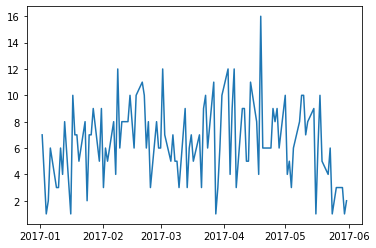

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# time series plot of actions sorted --> bit boring
pandasDF['date_time'] = pd.to_datetime(pandasDF["date_time"])
pandasDF['date'] = pandasDF['date_time'].dt.date
groupedByDateDF = pandasDF.groupby(pandasDF['date']).size().reset_index(name='Count')
plt.plot(groupedByDateDF['date'], groupedByDateDF['Count'])
plt.show()


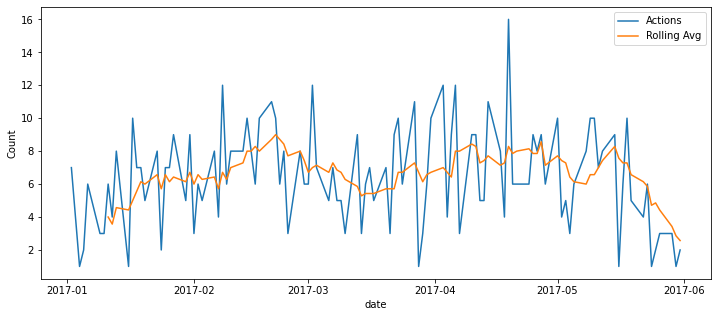

In [0]:
# with rolling avg
groupedByDateDF[ '7day_rolling_avg' ] = groupedByDateDF.Count.rolling( 7).mean()

# set figure size
plt.figure( figsize = ( 12, 5))
  
# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot(x = 'date',
             y = 'Count',
             data = groupedByDateDF,
             label = 'Actions')
  
# plot using rolling average
sns.lineplot( x = 'date', y = '7day_rolling_avg', data = groupedByDateDF, label = 'Rolling Avg')

plt.show()

In [0]:
# day with most actions
print("Day with Max Events: ", groupedByDateDF.loc[groupedByDateDF.Count == groupedByDateDF.Count.max()]['date'].item())
print("Max Events: ", groupedByDateDF.loc[groupedByDateDF.Count == groupedByDateDF.Count.max()]['Count'].item())

Day with Max Events:  2017-04-19
Max Events:  16


In [0]:
# which actions happened on that peak date

from datetime import date
peak_actions_date = date(2017, 4, 19)

peak_actions_date
pandasDF[pandasDF.date == peak_actions_date][['action', 'org_resource']].sort_values('action')

,action,org_resource
511,Blood test,Lab
524,Blood test,Lab
531,Blood test,Lab
523,First consult,Dr. Bob
530,First consult,Dr. Anna
493,Medicine,Pharmacy
528,Medicine,Pharmacy
498,Physical test,Nurse Corey
510,Physical test,Nurse Jesse
518,Physical test,Nurse Jesse


In [0]:
# days with least actions
print("Days with Least Events: \n", groupedByDateDF.loc[groupedByDateDF.Count == groupedByDateDF.Count.min()].sort_values("date"))

Days with Least Events: 
            date  Count  7day_rolling_avg
1    2017-01-04      1               NaN
9    2017-01-16      1          4.428571
60   2017-03-28      1          6.714286
95   2017-05-16      1          7.571429
101  2017-05-24      1          4.714286
105  2017-05-30      1          2.857143


In [0]:
# avg amount of actions per day
print('Avg actions per day: ', round(groupedByDateDF.Count.mean(), 2))

Avg actions per day:  6.45


In [0]:
# what are the operating hours
pandasDF['time'] = pandasDF['date_time'].dt.strftime('%H:%M')
pandasDF.head()

# the operating hours of the system
print(min(pandasDF.time), " - ", max(pandasDF.time))

07:31  -  18:13


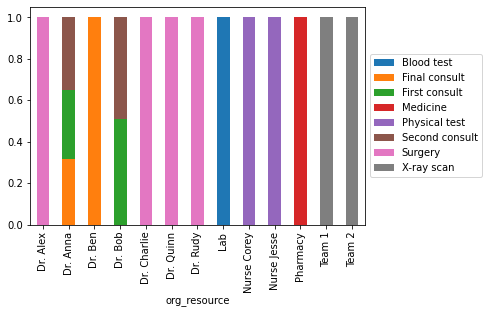

In [0]:
# which resource does which action
(pandasDF.groupby('org_resource')['action'].value_counts(normalize=True)
   .unstack('action').plot.bar(stacked=True)
)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [0]:
# how many actions do each resources have to do ? --> who should get a pay raise / has the bottleneck
pandasDF.groupby(['org_resource','action'])[['patient']].count().reset_index().sort_values('patient', ascending=False).reset_index()

,index,org_resource,action,patient
0,10,Lab,Blood test,100
1,13,Pharmacy,Medicine,80
2,12,Nurse Jesse,Physical test,57
3,3,Dr. Anna,Second consult,55
4,2,Dr. Anna,First consult,53
5,1,Dr. Anna,Final consult,50
6,4,Dr. Ben,Final consult,50
7,15,Team 2,X-ray scan,50
8,5,Dr. Bob,First consult,47
9,6,Dr. Bob,Second consult,45


In [0]:
# have all patients received final consult?
len(pandasDF[pandasDF['action'] == ' Final consult']) == 100

Out[277]: False

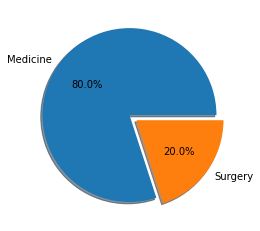

In [0]:
# how many patients have received surgery
groupBySurgery = pandasDF.loc[(pandasDF.action == 'Surgery') | (pandasDF.action == 'Medicine')].groupby('action', as_index=False).agg({'patient': 'nunique'})

plot = groupBySurgery.plot.pie(y = 'patient', labels= list(groupBySurgery.action.unique()), legend = False, autopct='%1.1f%%', explode= (0, 0.1), shadow=True, startangle=0)
plot.set_ylabel('')
plt.show()

In [0]:
# treatment_steps sorted by date
pandasDF = pandasDF.sort_values(["patient", "date_time"])
pandasDF["treatment_step"] = pandasDF.groupby(pandasDF['patient']).cumcount()
pandasDF["treatment_step_action"] = pandasDF.apply(lambda item: f'{item["treatment_step"]} {item["action"]}', axis=1)

In [0]:
# get possible treatment procedures
treatments = []
tempTreatment = []
for temp_patient in pandasDF.patient.unique():
    tempTreatment = list(pandasDF.loc[pandasDF['patient'] == f'{temp_patient}'].treatment_step_action.unique())
    if tempTreatment not in treatments:
        treatments.append(tempTreatment)

# name the procedures t1-t15 and print them
named_procedures = {}

for index, item in enumerate(treatments, start=0):
    named_procedures[f't{index + 1}'] = item
    print(f't{index + 1}', '_________')
    print(' - '.join(item))

t1 _________
0 First consult - 1 Blood test - 2 Physical test - 3 Second consult - 4 Surgery - 5 Final consult
t2 _________
0 First consult - 1 Physical test - 2 Blood test - 3 X-ray scan - 4 Second consult - 5 Medicine - 6 Final consult
t3 _________
0 First consult - 1 Physical test - 2 Blood test - 3 X-ray scan - 4 Second consult - 5 Surgery - 6 Final consult
t4 _________
0 First consult - 1 Blood test - 2 X-ray scan - 3 Physical test - 4 Second consult - 5 Medicine - 6 Final consult
t5 _________
0 First consult - 1 X-ray scan - 2 Physical test - 3 Blood test - 4 Second consult - 5 Medicine - 6 Final consult
t6 _________
0 First consult - 1 Physical test - 2 Blood test - 3 Second consult - 4 Medicine - 5 Final consult
t7 _________
0 First consult - 1 Physical test - 2 X-ray scan - 3 Blood test - 4 Second consult - 5 Medicine - 6 Final consult
t8 _________
0 First consult - 1 X-ray scan - 2 Blood test - 3 Physical test - 4 Second consult - 5 Medicine - 6 Final consult
t9 _________
0 F

In [0]:
# how many procedures are there?
print('unique procedures: ',  len(treatments))

unique procedures:  15


In [0]:
# assign treatment procedure to patients

# initialize
pandasDF['treatment_procedure'] = None

def setPatientProcedure(patient):
    patientProcedureTemp = list(pandasDF[pandasDF.patient == patient]['treatment_step_action'])
    return [k for k, v in named_procedures.items() if v == patientProcedureTemp][0]


for currentPatient in list(pandasDF.patient.unique()):
    pandasDF.loc[pandasDF.patient == currentPatient, 'treatment_procedure'] = setPatientProcedure(currentPatient)

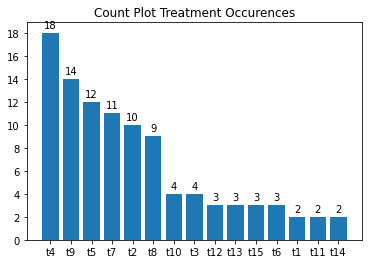

t4:  0 First consult - 1 X-ray scan - 2 Physical test - 3 Blood test - 4 Second consult - 5 Surgery - 6 Final consult


In [0]:
# which procedure is done how many times?

from matplotlib.ticker import MaxNLocator
import numpy as np

# group by procedures and get unique patients
count_procedures_df = pandasDF.groupby('treatment_procedure', as_index=False).agg({'patient': pd.Series.nunique}).sort_values('patient', ascending=False)
count_procedures_df.head()

# Create a figure object
fig = plt.figure()

# Add a subplot to the figure
ax = fig.add_subplot(111)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Create the bar plot
bars = ax.bar(count_procedures_df['treatment_procedure'], count_procedures_df['patient'])

# Loop through the bars and add annotations
for bar in bars:
   height = bar.get_height()
   ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
   textcoords="offset points", ha='center', va='bottom')

# Show the plot
plt.title('Count Plot Treatment Occurences')
plt.show()

print('t4: ', ' - '.join(named_procedures['t14']))

In [0]:
# how many steps does each procedure have? 
for procedure in named_procedures.items():
    print(procedure[0], ': has', len(procedure[1]), 'steps.')

t1 : has 6 steps.
t2 : has 7 steps.
t3 : has 7 steps.
t4 : has 7 steps.
t5 : has 7 steps.
t6 : has 6 steps.
t7 : has 7 steps.
t8 : has 7 steps.
t9 : has 7 steps.
t10 : has 7 steps.
t11 : has 6 steps.
t12 : has 6 steps.
t13 : has 7 steps.
t14 : has 7 steps.
t15 : has 7 steps.


In [0]:
groupByTreatment = pandasDF.groupby(['action', 'treatment_step_action'], as_index=False).size().sort_values('action')
groupByTreatment

,action,treatment_step_action,size
0,Blood test,1 Blood test,40
1,Blood test,2 Blood test,32
2,Blood test,3 Blood test,28
3,Final consult,5 Final consult,10
4,Final consult,6 Final consult,90
5,First consult,0 First consult,100
6,Medicine,4 Medicine,6
7,Medicine,5 Medicine,74
10,Physical test,3 Physical test,31
8,Physical test,1 Physical test,33


In [0]:
# time in between paths

# sort
pandasDF['date_time'] = pandasDF.groupby('patient')['date_time'].apply(lambda x: x.sort_values())

# pandasDF['diff_to_previous'] / pandasDF['previous_treatment_step']
pandasDF['diff_to_previous'] = pandasDF.groupby('patient')['date_time'].diff() / np.timedelta64(1, 'D')
pandasDF['diff_to_previous'] = pandasDF['diff_to_previous'].fillna(0)
df_grouped_previous = pandasDF.groupby(['patient'], sort=False).apply(lambda x: x['treatment_step_action'].shift(1)).reset_index()
pandasDF['previous_treatment_step'] = df_grouped_previous['treatment_step_action']

In [0]:
# pandasDF['diff_to_next'] / pandasDF['next_treatment_step']
pandasDF['diff_to_next'] = ((pandasDF['date_time'] - pandasDF['date_time'].shift(periods = -1)) /np.timedelta64(1, 'D')) *-1
pandasDF['diff_to_next'] = pandasDF.groupby('patient')['date_time'].apply(lambda x: x.shift(periods = -1))
pandasDF['diff_to_next'] = (pandasDF['diff_to_next'] - pandasDF['date_time']) / np.timedelta64(1, 'D')
pandasDF['diff_to_next'] = pandasDF['diff_to_next'].fillna(0)
df_grouped_next = pandasDF.groupby('patient', sort=False).apply(lambda x: x['treatment_step_action'].shift(-1))
pandasDF['next_treatment_step'] = df_grouped_next.values

In [0]:
#pandasDF['time_in_system']
df_grouped_time_in_system = pandasDF.groupby('patient')['date_time'].apply(lambda x: (x.max() - x.min()) / np.timedelta64(1, 'D') ).reset_index()
df_grouped_time_in_system = df_grouped_time_in_system.rename(columns={'date_time': 'time_in_system'})

pandasDF = pd.merge(pandasDF, df_grouped_time_in_system, on='patient')

In [0]:
groupBySankeyPlot = pandasDF.groupby(['treatment_step_action', 'next_treatment_step'], as_index=False).size()
groupBySankeyPlot['sources'] = groupBySankeyPlot.groupby('treatment_step_action').ngroup()
tempDict = groupBySankeyPlot.set_index('treatment_step_action')['sources'].to_dict()
groupBySankeyPlot['targets'] = groupBySankeyPlot['next_treatment_step'].apply(lambda item: tempDict[item] if item in tempDict else 16 if item == '5  Final consult' else 17)

new_row = {'treatment_step_action': '5  Final consult', 'next_treatment_step': None, 'size': 0, 'sources': None, 'targets': None}
groupBySankeyPlot = groupBySankeyPlot.append(new_row, ignore_index=True)
new_row = {'treatment_step_action':'6  Final consult', 'next_treatment_step': None, 'size': 0, 'sources': None, 'targets': None}
groupBySankeyPlot = groupBySankeyPlot.append(new_row, ignore_index=True)

<command-4426418642689932>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<command-4426418642689932>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [0]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(groupBySankeyPlot['treatment_step_action'].unique()),
      color = "blue"
    ),
    link = dict( 
      source = list(groupBySankeyPlot['sources']), # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = list(groupBySankeyPlot['targets']),
      value = list(groupBySankeyPlot['size'])
))])

fig.update_layout(title_text="Procedure Sankey", font_size=15)
fig.show()

In [0]:
# final amount of columns
print(pandasDF.columns)
print(len(pandasDF.columns))

Index(['id', 'patient_id', 'patient', 'action', 'org_resource', 'date_time',
       'time', 'treatment_step', 'treatment_step_action',
       'treatment_procedure', 'diff_to_previous', 'previous_treatment_step',
       'diff_to_next', 'next_treatment_step', 'time_in_system'],
      dtype='object')
15


In [0]:
# write to table
sample_table = spark.createDataFrame(pandasDF)
sample_table.write.format('delta').mode("overwrite").saveAsTable('health_care')

In [0]:
%sql
SELECT *
FROM health_care
LIMIT 5

id,patient_id,patient,action,org_resource,date_time,time,treatment_step,treatment_step_action,treatment_procedure,diff_to_previous,previous_treatment_step,diff_to_next,next_treatment_step,time_in_system
0,0,patient 0,First consult,Dr. Anna,2017-01-02T11:40:11.000+0000,11:40,0,0 First consult,t1,0.0,null,0.046782407407407404,1 Blood test,6.86755787037037
1,0,patient 0,Blood test,Lab,2017-01-02T12:47:33.000+0000,12:47,1,1 Blood test,t1,0.046782407407407404,0 First consult,0.004363425925925926,2 Physical test,6.86755787037037
2,0,patient 0,Physical test,Nurse Jesse,2017-01-02T12:53:50.000+0000,12:53,2,2 Physical test,t1,0.004363425925925926,1 Blood test,0.1439351851851852,3 Second consult,6.86755787037037
3,0,patient 0,Second consult,Dr. Anna,2017-01-02T16:21:06.000+0000,16:21,3,3 Second consult,t1,0.1439351851851852,2 Physical test,2.876423611111111,4 Surgery,6.86755787037037
4,0,patient 0,Surgery,Dr. Charlie,2017-01-05T13:23:09.000+0000,13:23,4,4 Surgery,t1,2.876423611111111,3 Second consult,3.796053240740741,5 Final consult,6.86755787037037


In [0]:
%sql
INSERT INTO health_care (id, patient, action, date_time)
VALUES (100 ,"patient 100", "First consult", "2017-06-01T11:40:11.000+0000");

num_affected_rows,num_inserted_rows
1,1


In [0]:
%sql
SELECT *
FROM health_care
where patient = "patient 100"

id,patient_id,patient,action,org_resource,date_time,time,treatment_step,treatment_step_action,treatment_procedure,diff_to_previous,previous_treatment_step,diff_to_next,next_treatment_step,time_in_system
100,null,patient 100,First consult,null,2017-06-01T11:40:11.000+0000,null,null,null,null,null,null,null,null,null


## 5. Results & Limitations
-

## 6. Sources